# Dialogue Summarization with BART

This project uses the BART model to summarize dialogues from the SAMSUM dataset.


**Libraries Used:**
- datasets
- transformers
- torch
- evaluate
- numpy
- tqdm
- flask
- pyngrok

**Project Overview:**  
This notebook demonstrates the process of fine-tuning a BART model for dialogue summarization using the SAMSUM dataset. It includes steps for data loading and preprocessing, model training and evaluation, and setting up a simple API for summarization.

# Install the Dependencies

In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

#Import the Libraries

In [ ]:
import nltk
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import numpy as np
from transformers import BartForConditionalGeneration, Trainer, TrainingArguments,EarlyStoppingCallback,DataCollatorForSeq2Seq,BartTokenizer
import torch
from datasets import DatasetDict,Dataset
import evaluate
from tqdm import tqdm
import shutil
from google.colab import files
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Read the dataset


In [ ]:
data_train=pd.read_csv("/content/samsum-train.csv")
data_val = pd.read_csv("samsum-validation.csv")
data_test = pd.read_csv("samsum-test.csv")

# PreProcessing

# Drop Duplicates and NA values

In [4]:
data_train.drop_duplicates(subset=['dialogue'],inplace=True)
data_train.dropna(axis=0,inplace=True)
data_val.drop_duplicates(subset=['dialogue'],inplace=True)
data_val.dropna(axis=0,inplace=True)
data_test.drop_duplicates(subset=['dialogue'],inplace=True)
data_test.dropna(axis=0,inplace=True)

# Information about dataset

Let us look at datatypes and shape of the dataset

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14264 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14264 non-null  object
 1   dialogue  14264 non-null  object
 2   summary   14264 non-null  object
dtypes: object(3)
memory usage: 445.8+ KB


In [12]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text):
    """
    Clean the input text by removing HTML tags, non-word characters (except for specified punctuation),
    extra whitespace, and converting to lowercase.
    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'[^\w\s.,?!:;\'-]', '', text)

    text = ' '.join(text.split())

    text = text.lower()

    return text.strip()

In [13]:
cleaned_text = []
for t in data_train['dialogue']:
    cleaned_text.append(text_cleaner(t))

Let us look at the first five preprocessed dialogue

In [15]:
cleaned_text[:5]

["amanda: i baked cookies. do you want some? jerry: sure! amanda: i'll bring you tomorrow :-",
 'olivia: who are you voting for in this election? oliver: liberals as always. olivia: me too!! oliver: great',
 "tim: hi, what's up? kim: bad mood tbh, i was going to do lots of stuff but ended up procrastinating tim: what did you plan on doing? kim: oh you know, uni stuff and unfucking my room kim: maybe tomorrow i'll move my ass and do everything kim: we were going to defrost a fridge so instead of shopping i'll eat some defrosted veggies tim: for doing stuff i recommend pomodoro technique where u use breaks for doing chores tim: it really helps kim: thanks, maybe i'll do that tim: i also like using post-its in kaban style",
 "edward: rachel, i think i'm in ove with bella.. rachel: dont say anything else.. edward: what do you mean?? rachel: open your fuing door.. i'm outside",
 "sam: hey overheard rick say something sam: i don't know what to do :- naomi: what did he say?? sam: he was talki

In [14]:
cleaned_summary = []
for t in data_train['summary']:
    cleaned_summary.append(text_cleaner(t))

Let us look at the first 10 preprocessed summaries

In [16]:
cleaned_summary[:10]

['amanda baked cookies and will bring jerry some tomorrow.',
 'olivia and olivier are voting for liberals in this election.',
 'kim may try the pomodoro technique recommended by tim to get more stuff done.',
 'edward thinks he is in love with bella. rachel wants edward to open his door. rachel is outside.',
 'sam is confused, because he overheard rick complaining about him as a roommate. naomi thinks sam should talk to rick. sam is not sure what to do.',
 "wyatt reminds neville his wedding anniversary is on the 17th of september. neville's wife is upset and it might be because neville forgot about their anniversary.",
 "john didn't show up for class due to some work issues with his boss. cassandra, his teacher told him which exercises to do, and which chapter to study. they are going to meet up for a beer sometime this week after class.",
 'sarah sends james an instrumental song he might like. james knows the song. the brain connects the songs to the context they were played in and bri

In [17]:
data_train['cleaned_text']=cleaned_text
data_train['cleaned_summary']=cleaned_summary

In [24]:
cleaned_text = []
for t in data_val['dialogue']:
    cleaned_text.append(text_cleaner(t))
cleaned_summary = []
for t in data_val['summary']:
    cleaned_summary.append(text_cleaner(t))
data_val['cleaned_text']=cleaned_text
data_val['cleaned_summary']=cleaned_summary

In [23]:
cleaned_text = []
for t in data_test['dialogue']:
    cleaned_text.append(text_cleaner(t))
cleaned_summary = []
for t in data_test['summary']:
    cleaned_summary.append(text_cleaner(t))
data_test['cleaned_text']=cleaned_text
data_test['cleaned_summary']=cleaned_summary

#Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

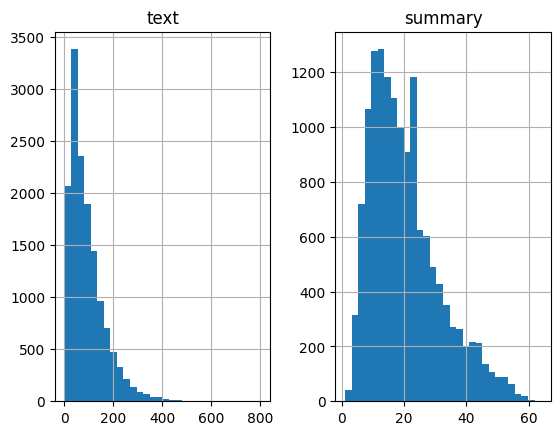

In [25]:

text_word_count = []
summary_word_count = []

for i in data_train['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data_train['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 60 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 60

In [26]:
cnt=0
for i in data_train['cleaned_summary']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(cnt/len(data_train['cleaned_summary']))

0.9999298934380259


We observe that 99999% of the summaries have length below 60. So, we can fix maximum length of summary to 60.

Let us fix the maximum length of review to 60

In [27]:
max_text_len=400
max_summary_len=60

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [43]:
cleaned_text =np.array(data_train['cleaned_text'])
cleaned_summary=np.array(data_train['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_train=pd.DataFrame({'text':short_text,'summary':short_summary})

In [44]:
cleaned_text =np.array(data_val['cleaned_text'])
cleaned_summary=np.array(data_val['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_val=pd.DataFrame({'text':short_text,'summary':short_summary})

In [45]:
cleaned_text =np.array(data_test['cleaned_text'])
cleaned_summary=np.array(data_test['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df_test=pd.DataFrame({'text':short_text,'summary':short_summary})

**Save the preprocessed files**

In [70]:
df_train.to_csv('samsum_train_cleaned.csv', index=False)
df_val.to_csv('samsum_val_cleaned.csv', index=False)
df_test.to_csv('samsum_test_cleaned.csv', index=False)

# Tokenizing

First convert them to dataset to be compitable with the tokenizer

In [ ]:
dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "val":Dataset.from_pandas(df_val),
    "test":Dataset.from_pandas(df_test)
})

In [48]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
def preprocess_function(examples):
    """
    Preprocess dataset examples for model training.

    Args:
        examples: A dictionary with 'dialogue' and 'summary' keys containing lists of strings.

    Returns:
        A dictionary with 'input_ids', 'attention_mask', and 'labels' as lists of lists of integers.
    """
    inputs = tokenizer(
        examples["text"],
        max_length=400,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"],
            max_length=60,
            truncation=True,
            padding="max_length"
        )
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_dataset = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/14194 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/812 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14194 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/812 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/812 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset.save_to_disk("/kaggle/working/tokenized_samsum")

# Training

Load facebook/bart-base model

In [54]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [55]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    logging_dir="/kaggle/working/logs",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    run_name="bart-samsum-training",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.781600,0.701361
2,0.725300,0.682749
3,0.601100,0.671507


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Save the model to use later

In [ ]:
trainer.save_model("/kaggle/working/bart-samsum")

# Evaluation

In [ ]:
def compute_metrics(eval_pred):
    """
    Compute ROUGE metrics for model evaluation based on predictions and labels.

    Args:
        eval_pred: A tuple containing predictions and labels, each as a list of lists of integers.

    Returns:
        A dictionary mapping ROUGE metric names to their values multiplied by 100.
    """
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return {key: value * 100 for key, value in result.items()}

In [ ]:
def evaluate_in_chunks(dataset, batch_size=1):
    """
    Evaluate a model on a dataset in chunks to manage memory usage efficiently.

    Args:
        dataset: A Hugging Face Dataset containing preprocessed input data and labels.
        batch_size: Number of examples to process per chunk (default: 1).

    Returns:
        A tuple of (predictions, labels), each as a list of lists of integers.
    """
    all_preds = []
    all_labels = []
    model.eval()

    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:i+batch_size]
        inputs = {
            k: torch.tensor(v).to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]
        }
        labels = torch.tensor(batch["labels"]).to("cuda")

        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                num_beams=4,
                early_stopping=True
            )
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        torch.cuda.empty_cache()

    return all_preds, all_labels

In [69]:
torch.cuda.empty_cache()
rouge = evaluate.load("rouge")

all_preds, all_labels = evaluate_in_chunks(tokenized_dataset["test"], batch_size=1)
metrics = compute_metrics((all_preds, all_labels))
print("ROUGEDZ Scores on Test Set:", metrics)

100%|██████████| 812/812 [05:29<00:00,  2.46it/s]


ROUGEDZ Scores on Test Set: {'rouge1': np.float64(50.19687928059688), 'rouge2': np.float64(26.144686772124736), 'rougeL': np.float64(41.79952580123242), 'rougeLsum': np.float64(41.786471721975715)}


Save the final weights

In [ ]:
shutil.make_archive("/kaggle/working/bart-samsum", 'zip', "/kaggle/working/bart-samsum")

In [71]:
files.download('/kaggle/working/bart-samsum.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **API**

In [ ]:
app = Flask(__name__)

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("bart-samsum")
model.to("cuda" if torch.cuda.is_available() else "cpu")

@app.route("/summarize", methods=["POST"])
def summarize():
    try:
        data = request.get_json()
        dialogue = data.get("dialogue")
        if not dialogue or not isinstance(dialogue, str):
            return jsonify({"error": "Invalid or missing dialogue"}), 400
        inputs = tokenizer(dialogue, return_tensors="pt", max_length=1024, truncation=True).to(model.device)
        summary_ids = model.generate(inputs["input_ids"], max_length=50, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return jsonify({"summary": summary})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route("/", methods=["GET"])
def index():
    return "Dialogue Summarization API is running. Use POST /summarize with JSON data."

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)